1. Setup and Get Data

1.1 Install Dependencies and Setup

In [13]:
!pip install tensorflow opencv-python matplotlib albumentations

  Using cached tensorflow-2.13.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (479.6 MB)
  Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (63.0 MB)
  Using cached albumentations-1.4.18-py3-none-any.whl (224 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached keras-2.13.1-py3-none-any.whl (1.7 MB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl (30 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl (133 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached protobuf-4.25.6-cp37-abi3-manylinux2014_x86_64.whl (294 kB)
  Using cached tensorflow_io_gcs_filesystem-0.34.0-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.4 MB)
  Using cached tensorflow_estimator-2.13.0-py2.py3-none-any.whl (440 kB)
  Using cached tensorboard-2.13.0-py3-none-any.whl (5.6 

2. Review Dataset and Build Image Loading Function

2.1 Import TF and Deps

In [14]:
import tensorflow as tf
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt

2025-03-04 17:36:10.458487: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-04 17:36:10.484643: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-04 17:36:10.620010: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-04 17:36:10.620966: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-04 17:36:11.271363: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

2.2 Load Image into TF Data Pipeline

In [15]:
images = tf.data.Dataset.list_files('data/frame_images_DB/*/*/*.jpg', shuffle=False)

In [16]:
images.as_numpy_iterator().next()

b'data/frame_images_DB/AJ_Cook/0/0.123.jpg'

In [17]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [18]:
images = images.map(load_image)

In [ ]:
images.as_numpy_iterator().next()

In [20]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

2.3 View Raw Images wit Matplotlib

In [21]:
image_generator = images.batch(4).as_numpy_iterator()

In [22]:
plot_images = image_generator.next()

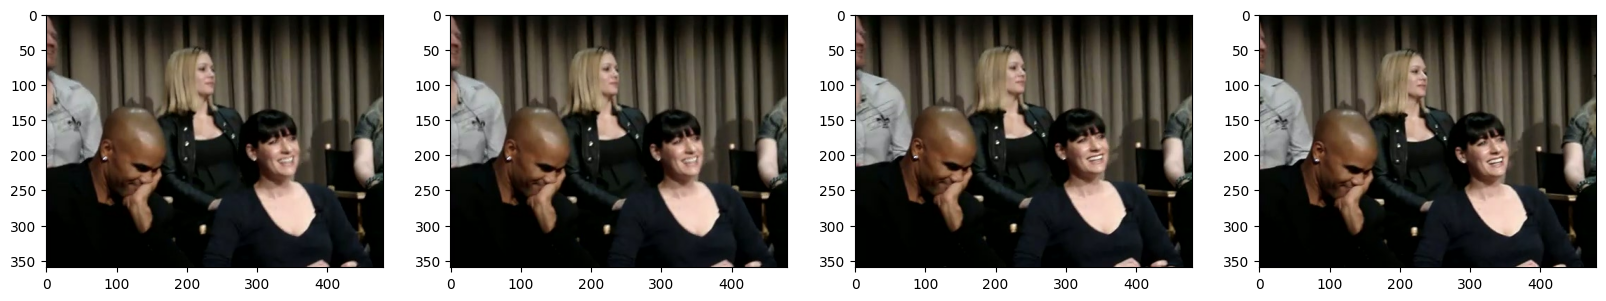

In [23]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

3. Partition Unaugmented Data

3.1 Manually Split Data into Train, Test, and Val (I used arbitrary folders of videos of people)

In [24]:
90*0.7 # 63 to train

62.99999999999999

In [25]:
90*0.15 # 14 and 13 to test and val

13.5

3.2 Move the Matching labels (did that along with data already)

4. Apply Image Augmentations on Images and Labels using Albumentations (not augmenting our images...)

4.1 Normalize the Center Point, Width, and Height for Every Label of Every Image

--- ### @@@ CODE FOR DATASET NORMALIZATION GOES HERE @@@ ### ---

5. Load Augmented Images to Tensorflow Dataset (just use regular images)

5.1 Load Images to Tensorflow Dataset

In [112]:
train_images = tf.data.Dataset.list_files('data/train/*/*/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [113]:
test_images = tf.data.Dataset.list_files('data/test/*/*/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [114]:
val_images = tf.data.Dataset.list_files('data/val/*/*/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [ ]:
train_images.as_numpy_iterator().next()

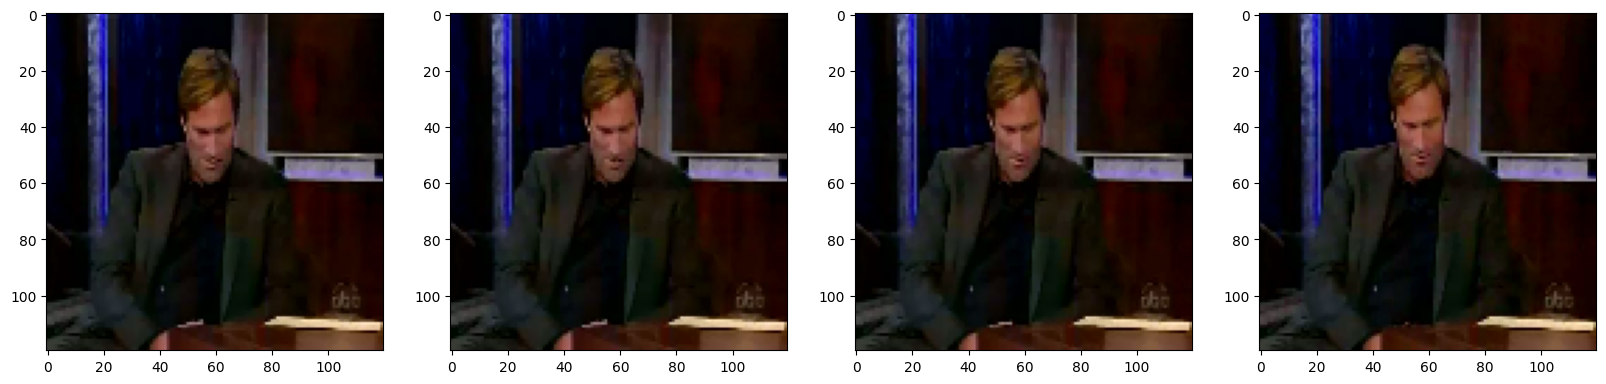

In [201]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(train_images.batch(4).as_numpy_iterator().next()):
    ax[idx].imshow(image)
plt.show()

6. Prepare Labels

6.1 Build Label Loading Function

TODO: load_labels is broken, need to modify datasets...

We need to write a python script that goes through the gathered training, validation, and testing datasets and 
normalizes the centers, widths, and height for each label.


In [353]:
def load_labels(label_path):
    bbox = []
    file_content = tf.io.read_file(label_path)
    tokens = tf.strings.split(file_content, sep=",")

    # Collect relavent bbox data (center, width, and height)
    center_point = (tf.strings.to_number(tokens[2], out_type=tf.float32), 
                    tf.strings.to_number(tokens[3], out_type=tf.float32))
    width = tf.strings.to_number(tokens[4])
    height = tf.strings.to_number(tokens[5])

    # Calculate normalized corner points of bbox
    top_left = (center_point[0] - 0.5 * width, center_point[1] + 0.5 * height) 
    bot_right = (center_point[0] + 0.5 * width, center_point[1] - 0.5 * height)
    
    return (0, (top_left, bot_right))

In [354]:
print(load_labels("data/train/labels/Aaron_EckhartQsZ0QsZ0.555.txt"))

(0, ((<tf.Tensor: shape=(), dtype=float32, numpy=195.0>, <tf.Tensor: shape=(), dtype=float32, numpy=179.0>), (<tf.Tensor: shape=(), dtype=float32, numpy=279.0>, <tf.Tensor: shape=(), dtype=float32, numpy=95.0>)))


6.2 Load Labels to Tensorflow Dataset

In [355]:
train_labels = tf.data.Dataset.list_files('data/train/labels/*.txt', shuffle=False)
train_labels = train_labels.map(load_labels)

In [356]:
test_labels = tf.data.Dataset.list_files('data/test/labels/*.txt', shuffle=False)
test_labels = test_labels.map(load_labels)

In [357]:
val_labels = tf.data.Dataset.list_files('data/val/labels/*.txt', shuffle=False)
val_labels = val_labels.map(load_labels)

In [358]:
train_labels.as_numpy_iterator().next()

(0, ((195.0, 179.0), (279.0, 95.0)))

7. Combine Label and Image Samples

7.1 Check Partition Lengths

In [198]:
len(train_images), len(train_labels)

(1054, 1054)